In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (0.5*pi*torch.cos(x)+(x-pi*0.5))*torch.cos(t)

def initial_condition_u(x):
    return 0.5*pi*torch.cos(x) + (x - pi*0.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x) 

def acc_a(x, t):
    return -(0.5*pi*torch.cos(x)+(x-pi*0.5))*torch.cos(t)

In [3]:
# Define the exact solution
def exact_solution_p(x, t):
    return 0.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 0.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x) 

In [4]:
# Additional data for acceleration

data_pts = 2000

x_1 = 0*torch.ones((data_pts)).reshape(-1,1)
x_2 = 0.25*pi*torch.ones((data_pts)).reshape(-1,1)
x_3 = 0.5*pi*torch.ones((data_pts)).reshape(-1,1)
x_4 = 0.75*pi*torch.ones((data_pts)).reshape(-1,1)
x_5 = pi*torch.ones((data_pts)).reshape(-1,1)

t_data_pts = torch.rand((data_pts, 1))

fir_loc = torch.cat([x_1, t_data_pts],1)
sec_loc = torch.cat([x_2, t_data_pts],1)
thr_loc = torch.cat([x_3, t_data_pts],1)
fou_loc = torch.cat([x_4, t_data_pts],1)
fif_loc = torch.cat([x_5, t_data_pts],1)

a1 = acc_a(fir_loc[:, 0], fir_loc[:, 1])
a2 = acc_a(sec_loc[:, 0], sec_loc[:, 1])
a3 = acc_a(thr_loc[:, 0], thr_loc[:, 1])
a4 = acc_a(fou_loc[:, 0], fou_loc[:, 1])
a5 = acc_a(fif_loc[:, 0], fif_loc[:, 1])

In [5]:
# assigning number of points
initial_pts = 2000 
left_boundary_pts = 2000 
right_boundary_pts = 2000
residual_pts = 10000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1)
w_t_init = torch.cat([u_t_init, p_t_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, w_t_init, b_left,  b_right), batch_size=2000, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_xx = grad_u_hat_xx[:, 0].reshape(-1,1)
                
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_xx = grad_p_hat_xx[:, 0].reshape(-1,1)
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_tt = grad_u_hat_tt[:, 1].reshape(-1,1)
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_tt = grad_p_hat_tt[:, 1].reshape(-1,1)
                
                
                # residual calculation
                fir_loc.requires_grad = True
                sec_loc.requires_grad = True
                thr_loc.requires_grad = True
                fou_loc.requires_grad = True
                fif_loc.requires_grad = True
              
                
                w_1 = model(fir_loc)
                w_2 = model(sec_loc)
                w_3 = model(thr_loc)
                w_4 = model(fou_loc)
                w_5 = model(fif_loc)
               
                
                # First Location
                
                u_hat1 = w_1[:, 0].reshape(-1,1)
                inputs = torch.ones(data_pts, 1 )
                grad_u_hat1 = torch.autograd.grad(u_hat1.reshape(-1,1),  fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t1 = grad_u_hat1[:, 1].reshape(-1,1)
                u_x1 = grad_u_hat1[:, 0].reshape(-1,1)
                grad_u_hat_xx1 = torch.autograd.grad(u_x1, fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx1 = grad_u_hat_xx1[:, 0].reshape(-1,1)
                
                grad_u_hat_tt1 = torch.autograd.grad(u_t1, fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt1 = grad_u_hat_tt1[:, 1].reshape(-1,1)
                
                
                # Second Location
                u_hat2 = w_2[:, 0].reshape(-1,1)
                grad_u_hat2 = torch.autograd.grad(u_hat2.reshape(-1,1), sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t2 = grad_u_hat2[:, 1].reshape(-1,1)
                u_x2 = grad_u_hat2[:, 0].reshape(-1,1)
                grad_u_hat_xx2 = torch.autograd.grad(u_x2, sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx2 = grad_u_hat_xx2[:, 0].reshape(-1,1)
                
                grad_u_hat_tt2 = torch.autograd.grad(u_t2, sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt2 = grad_u_hat_tt2[:, 1].reshape(-1,1)
                
                
                # Third Location
                
                u_hat3 = w_3[:, 0].reshape(-1,1)
                grad_u_hat3 = torch.autograd.grad(u_hat3.reshape(-1,1), thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t3 = grad_u_hat3[:, 1].reshape(-1,1)
                u_x3 = grad_u_hat3[:, 0].reshape(-1,1)
                grad_u_hat_xx3 = torch.autograd.grad(u_x3, thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx3 = grad_u_hat_xx3[:, 0].reshape(-1,1)
                
                grad_u_hat_tt3 = torch.autograd.grad(u_t3, thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt3 = grad_u_hat_tt3[:, 1].reshape(-1,1)
                
                # Fourth Location
                
                u_hat4 = w_4[:, 0].reshape(-1,1)
                grad_u_hat4 = torch.autograd.grad(u_hat4.reshape(-1,1), fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t4 = grad_u_hat4[:, 1].reshape(-1,1)
                u_x4 = grad_u_hat4[:, 0].reshape(-1,1)
                grad_u_hat_xx4 = torch.autograd.grad(u_x4, fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx4 = grad_u_hat_xx4[:, 0].reshape(-1,1)
                
                grad_u_hat_tt4 = torch.autograd.grad(u_t4, fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt4 = grad_u_hat_tt4[:, 1].reshape(-1,1)
                
                
                 
                # Fifth Location
                
                u_hat5 = w_5[:, 0].reshape(-1,1)
                grad_u_hat5 = torch.autograd.grad(u_hat5.reshape(-1,1), fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t5 = grad_u_hat5[:, 1].reshape(-1,1)
                grad_u_hat_tt5 = torch.autograd.grad(u_t5, fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt5 = grad_u_hat_tt5[:, 1].reshape(-1,1)
                
                u_x5 = grad_u_hat5[:, 0].reshape(-1,1)
                grad_u_hat_xx5 = torch.autograd.grad(u_x5, fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx5 = grad_u_hat_xx5[:, 0].reshape(-1,1)
                
                
                

             
              
                data1 = torch.mean((u_tt1.reshape(-1, ) - a1.reshape(-1, ))**p)
                data2 = torch.mean((u_tt2.reshape(-1, ) - a2.reshape(-1, ))**p)
                data3 = torch.mean((u_tt3.reshape(-1, ) - a3.reshape(-1, ))**p)
                data4 = torch.mean((u_tt4.reshape(-1, ) - a4.reshape(-1, ))**p)
                data5 = torch.mean((u_tt5.reshape(-1, ) - a5.reshape(-1, ))**p)
                
                
                # Item 1. below
                
                # For theta calculation
                
                
                 # First Location
                
                u_hat1 = w_1[:, 1].reshape(-1,1)
                inputs = torch.ones(data_pts, 1 )
                grad_u_hat1 = torch.autograd.grad(u_hat1.reshape(-1,1),  fir_loc, grad_outputs=inputs, create_graph=True)[0]
               
                p_x1 = grad_u_hat1[:, 0].reshape(-1,1)
                
                # Second Location
                u_hat2 = w_2[:, 1].reshape(-1,1)
                grad_u_hat2 = torch.autograd.grad(u_hat2.reshape(-1,1), sec_loc, grad_outputs=inputs, create_graph=True)[0]
                
                p_x2 = grad_u_hat2[:, 0].reshape(-1,1)
              
                
                # Third Location
                
                u_hat3 = w_3[:, 1].reshape(-1,1)
                grad_u_hat3 = torch.autograd.grad(u_hat3.reshape(-1,1), thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t3 = grad_u_hat3[:, 1].reshape(-1,1)
                p_x3 = grad_u_hat3[:, 0].reshape(-1,1)
                
                # Fourth Location
                
                u_hat4 = w_4[:, 1].reshape(-1,1)
                grad_u_hat4 = torch.autograd.grad(u_hat4.reshape(-1,1), fou_loc, grad_outputs=inputs, create_graph=True)[0]
                
                p_x4 = grad_u_hat4[:, 0].reshape(-1,1)
                
                 
                # Fifth Location
                
                u_hat5 = w_5[:, 1].reshape(-1,1)
                grad_u_hat5 = torch.autograd.grad(u_hat5.reshape(-1,1), fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t5 = grad_u_hat5[:, 1].reshape(-1,1)
                p_x5 = grad_u_hat5[:, 0].reshape(-1,1)
                

             
                
                theta_x_1 = torch.cos(t_data_pts)- pi*0.5*torch.sin(x_1)*torch.cos(t_data_pts) - u_tt1 + u_xx1
                theta_x_2 = torch.cos(t_data_pts)- pi*0.5*torch.sin(x_2)*torch.cos(t_data_pts) - u_tt2 + u_xx2
                theta_x_3 = torch.cos(t_data_pts)- pi*0.5*torch.sin(x_3)*torch.cos(t_data_pts) - u_tt3 + u_xx3
                theta_x_4 = torch.cos(t_data_pts)- pi*0.5*torch.sin(x_4)*torch.cos(t_data_pts)  - u_tt4 + u_xx4
                theta_x_5 = torch.cos(t_data_pts)- pi*0.5*torch.sin(x_5)*torch.cos(t_data_pts) - u_tt5 + u_xx5


                datap1 = torch.mean((p_x1.reshape(-1, ) - theta_x_1.reshape(-1, ))**p)
                datap2 = torch.mean((p_x2.reshape(-1, ) - theta_x_2.reshape(-1, ))**p)
                datap3 = torch.mean((p_x3.reshape(-1, ) - theta_x_3.reshape(-1, ))**p)
                datap4 = torch.mean((p_x4.reshape(-1, ) - theta_x_4.reshape(-1, ))**p)
                datap5 = torch.mean((p_x5.reshape(-1, ) - theta_x_5.reshape(-1, ))**p)
                
                
                
                
#                 # Item 1. below
#                 loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:,0].reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + 0.1*torch.mean((u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
#                 loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((p_initial_t.reshape(-1, ) - w_initial_t[:,1].reshape(-1, ))**p) + 0.1*torch.mean((p_tt.reshape(-1, )  + u_x.reshape(-1, ) - p_xx.reshape(-1, ) - torch.cos(interior[:, 1]).reshape(-1, ) + pi*0.5*torch.sin(interior[:, 0])*torch.cos(interior[:, 1]).reshape(-1, ))**p)+torch.mean((p_bd_left_pred_.reshape(-1,)- p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
#                 loss = loss1 + loss2
#                 #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
                
    
    
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:,0].reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) +torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((p_initial_t.reshape(-1, ) - w_initial_t[:,1].reshape(-1, ))**p) +torch.mean((p_bd_left_pred_.reshape(-1,)- p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                
                loss_u = loss1 + data1 + data2 + data3 + data4 + data5
                
                loss_p = loss2 + datap1 + datap2 + datap3 + datap4 + datap5
                
                loss = loss_u + loss_p
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 15000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  880.8182373046875
################################  1  ################################
Loss:  804.4761352539062
################################  2  ################################
Loss:  688.8008422851562
################################  3  ################################
Loss:  588.212158203125
################################  4  ################################
Loss:  504.0548400878906
################################  5  ################################
Loss:  432.58233642578125
################################  6  ################################
Loss:  372.9917297363281
################################  7  ################################
Loss:  324.46759033203125
################################  8  ################################
Loss:  285.5126953125
################################  9  ################################
Loss:  254.31439208984375
################################  10  #############

Loss:  2.5321927070617676
################################  86  ################################
Loss:  2.4973065853118896
################################  87  ################################
Loss:  2.4627151489257812
################################  88  ################################
Loss:  2.4280688762664795
################################  89  ################################
Loss:  2.3932876586914062
################################  90  ################################
Loss:  2.3580403327941895
################################  91  ################################
Loss:  2.3223986625671387
################################  92  ################################
Loss:  2.286015510559082
################################  93  ################################
Loss:  2.249173402786255
################################  94  ################################
Loss:  2.211444854736328
################################  95  ################################
Loss:  2.173428535461426
########

Loss:  1.1802692413330078
################################  171  ################################
Loss:  1.176656723022461
################################  172  ################################
Loss:  1.1734024286270142
################################  173  ################################
Loss:  1.1703602075576782
################################  174  ################################
Loss:  1.1676257848739624
################################  175  ################################
Loss:  1.1650725603103638
################################  176  ################################
Loss:  1.1627538204193115
################################  177  ################################
Loss:  1.1605777740478516
################################  178  ################################
Loss:  1.1585606336593628
################################  179  ################################
Loss:  1.1566340923309326
################################  180  ################################
Loss:  1.154793977737

Loss:  0.9618871212005615
################################  257  ################################
Loss:  0.9565721154212952
################################  258  ################################
Loss:  0.9508365392684937
################################  259  ################################
Loss:  0.9444652795791626
################################  260  ################################
Loss:  0.938035249710083
################################  261  ################################
Loss:  0.9318915605545044
################################  262  ################################
Loss:  0.9262672066688538
################################  263  ################################
Loss:  0.9208965301513672
################################  264  ################################
Loss:  0.9158951044082642
################################  265  ################################
Loss:  0.9106277823448181
################################  266  ################################
Loss:  0.906519412994

Loss:  0.47778433561325073
################################  341  ################################
Loss:  0.4749998450279236
################################  342  ################################
Loss:  0.47197669744491577
################################  343  ################################
Loss:  0.46872204542160034
################################  344  ################################
Loss:  0.46513330936431885
################################  345  ################################
Loss:  0.4612225890159607
################################  346  ################################
Loss:  0.4569244682788849
################################  347  ################################
Loss:  0.45215222239494324
################################  348  ################################
Loss:  0.447180837392807
################################  349  ################################
Loss:  0.4421081244945526
################################  350  ################################
Loss:  0.4372593

Loss:  0.18583175539970398
################################  425  ################################
Loss:  0.18505260348320007
################################  426  ################################
Loss:  0.18427774310112
################################  427  ################################
Loss:  0.18357247114181519
################################  428  ################################
Loss:  0.1828705072402954
################################  429  ################################
Loss:  0.18220534920692444
################################  430  ################################
Loss:  0.18151476979255676
################################  431  ################################
Loss:  0.18080168962478638
################################  432  ################################
Loss:  0.1800122708082199
################################  433  ################################
Loss:  0.1791025549173355
################################  434  ################################
Loss:  0.1779878

Loss:  0.11142706871032715
################################  509  ################################
Loss:  0.11084267497062683
################################  510  ################################
Loss:  0.11026585102081299
################################  511  ################################
Loss:  0.10970102250576019
################################  512  ################################
Loss:  0.10914948582649231
################################  513  ################################
Loss:  0.10862863063812256
################################  514  ################################
Loss:  0.10813640058040619
################################  515  ################################
Loss:  0.10768337547779083
################################  516  ################################
Loss:  0.10725004971027374
################################  517  ################################
Loss:  0.10684488713741302
################################  518  ################################
Loss:  0.1

Loss:  0.06908082962036133
################################  593  ################################
Loss:  0.0688355416059494
################################  594  ################################
Loss:  0.0685960203409195
################################  595  ################################
Loss:  0.06836705654859543
################################  596  ################################
Loss:  0.06814295053482056
################################  597  ################################
Loss:  0.06793010234832764
################################  598  ################################
Loss:  0.06771761178970337
################################  599  ################################
Loss:  0.06751177459955215
################################  600  ################################
Loss:  0.06730317324399948
################################  601  ################################
Loss:  0.06708651781082153
################################  602  ################################
Loss:  0.066

Loss:  0.0542435348033905
################################  678  ################################
Loss:  0.054101504385471344
################################  679  ################################
Loss:  0.053918372839689255
################################  680  ################################
Loss:  0.05378423631191254
################################  681  ################################
Loss:  0.053680192679166794
################################  682  ################################
Loss:  0.05357358604669571
################################  683  ################################
Loss:  0.05346698313951492
################################  684  ################################
Loss:  0.05337041988968849
################################  685  ################################
Loss:  0.05327296629548073
################################  686  ################################
Loss:  0.053177691996097565
################################  687  ################################
Loss:  

Loss:  0.043701402842998505
################################  762  ################################
Loss:  0.04351112246513367
################################  763  ################################
Loss:  0.04332472011446953
################################  764  ################################
Loss:  0.043136440217494965
################################  765  ################################
Loss:  0.04294919595122337
################################  766  ################################
Loss:  0.04274154454469681
################################  767  ################################
Loss:  0.042569875717163086
################################  768  ################################
Loss:  0.042415812611579895
################################  769  ################################
Loss:  0.04223538190126419
################################  770  ################################
Loss:  0.04209481552243233
################################  771  ################################
Loss: 

Loss:  0.031528208404779434
################################  846  ################################
Loss:  0.03141898661851883
################################  847  ################################
Loss:  0.03131045028567314
################################  848  ################################
Loss:  0.03120160475373268
################################  849  ################################
Loss:  0.031096089631319046
################################  850  ################################
Loss:  0.030988138169050217
################################  851  ################################
Loss:  0.030875246971845627
################################  852  ################################
Loss:  0.030760500580072403
################################  853  ################################
Loss:  0.030653245747089386
################################  854  ################################
Loss:  0.030537933111190796
################################  855  ################################
Los

Loss:  0.02536657266318798
################################  930  ################################
Loss:  0.025285983458161354
################################  931  ################################
Loss:  0.02520936354994774
################################  932  ################################
Loss:  0.02513260953128338
################################  933  ################################
Loss:  0.0250591728836298
################################  934  ################################
Loss:  0.02498711459338665
################################  935  ################################
Loss:  0.024917587637901306
################################  936  ################################
Loss:  0.024850869551301003
################################  937  ################################
Loss:  0.024789638817310333
################################  938  ################################
Loss:  0.0247320756316185
################################  939  ################################
Loss:  0

Loss:  0.017553146928548813
################################  1013  ################################
Loss:  0.017430726438760757
################################  1014  ################################
Loss:  0.017302321270108223
################################  1015  ################################
Loss:  0.017185350880026817
################################  1016  ################################
Loss:  0.017069218680262566
################################  1017  ################################
Loss:  0.016962286084890366
################################  1018  ################################
Loss:  0.016856156289577484
################################  1019  ################################
Loss:  0.016753198578953743
################################  1020  ################################
Loss:  0.016653189435601234
################################  1021  ################################
Loss:  0.016554655507206917
################################  1022  #######################

Loss:  0.011891968548297882
################################  1097  ################################
Loss:  0.011843517422676086
################################  1098  ################################
Loss:  0.01179584488272667
################################  1099  ################################
Loss:  0.011737778782844543
################################  1100  ################################
Loss:  0.011680630967020988
################################  1101  ################################
Loss:  0.011623731814324856
################################  1102  ################################
Loss:  0.011564284563064575
################################  1103  ################################
Loss:  0.011501500383019447
################################  1104  ################################
Loss:  0.011432936415076256
################################  1105  ################################
Loss:  0.011358530260622501
################################  1106  ########################

Loss:  0.007301602512598038
################################  1181  ################################
Loss:  0.007267956156283617
################################  1182  ################################
Loss:  0.0072343433275818825
################################  1183  ################################
Loss:  0.007200541906058788
################################  1184  ################################
Loss:  0.007166072726249695
################################  1185  ################################
Loss:  0.007130428683012724
################################  1186  ################################
Loss:  0.00709350174292922
################################  1187  ################################
Loss:  0.0070551005192101
################################  1188  ################################
Loss:  0.007015685550868511
################################  1189  ################################
Loss:  0.006975523661822081
################################  1190  #########################

Loss:  0.004541140981018543
################################  1265  ################################
Loss:  0.004508493933826685
################################  1266  ################################
Loss:  0.004478777758777142
################################  1267  ################################
Loss:  0.004451283253729343
################################  1268  ################################
Loss:  0.004426445811986923
################################  1269  ################################
Loss:  0.004403731785714626
################################  1270  ################################
Loss:  0.004383323714137077
################################  1271  ################################
Loss:  0.004364684224128723
################################  1272  ################################
Loss:  0.004347783047705889
################################  1273  ################################
Loss:  0.00433217640966177
################################  1274  ########################

Loss:  0.0032329661771655083
################################  1346  ################################
Loss:  0.003220971906557679
################################  1347  ################################
Loss:  0.0032133287750184536
################################  1348  ################################
Loss:  0.0032053589820861816
################################  1349  ################################
Loss:  0.0031963996589183807
################################  1350  ################################
Loss:  0.0031895595602691174
################################  1351  ################################
Loss:  0.0031824419274926186
################################  1352  ################################
Loss:  0.003174879588186741
################################  1353  ################################
Loss:  0.0031662045512348413
################################  1354  ################################
Loss:  0.0031559995841234922
################################  1355  ###############

Loss:  0.002403761027380824
################################  1427  ################################
Loss:  0.0023927981965243816
################################  1428  ################################
Loss:  0.0023813347797840834
################################  1429  ################################
Loss:  0.0023674170952290297
################################  1430  ################################
Loss:  0.0023564333096146584
################################  1431  ################################
Loss:  0.002344907261431217
################################  1432  ################################
Loss:  0.002332858042791486
################################  1433  ################################
Loss:  0.0023206095211207867
################################  1434  ################################
Loss:  0.0023079155944287777
################################  1435  ################################
Loss:  0.0022949487902224064
################################  1436  ################

Loss:  0.0016453457064926624
################################  1509  ################################
Loss:  0.001633640844374895
################################  1510  ################################
Loss:  0.001622305833734572
################################  1511  ################################
Loss:  0.0016109924763441086
################################  1512  ################################
Loss:  0.0015998848248273134
################################  1513  ################################
Loss:  0.0016032755374908447
################################  1514  ################################
Loss:  0.0015933297108858824
################################  1515  ################################
Loss:  0.0015839501284062862
################################  1516  ################################
Loss:  0.0015749887097626925
################################  1517  ################################
Loss:  0.0015664581442251801
################################  1518  ###############

Loss:  0.001249565277248621
################################  1590  ################################
Loss:  0.0012471225345507264
################################  1591  ################################
Loss:  0.0012447457993403077
################################  1592  ################################
Loss:  0.0012424607994034886
################################  1593  ################################
Loss:  0.0012402947759255767
################################  1594  ################################
Loss:  0.0012382708955556154
################################  1595  ################################
Loss:  0.0012363295536488295
################################  1596  ################################
Loss:  0.0012344071874395013
################################  1597  ################################
Loss:  0.0012325807474553585
################################  1598  ################################
Loss:  0.0012308720033615828
################################  1599  ##############

Loss:  0.0010138857178390026
################################  1671  ################################
Loss:  0.0010125149274244905
################################  1672  ################################
Loss:  0.0010111209703609347
################################  1673  ################################
Loss:  0.001009692787192762
################################  1674  ################################
Loss:  0.0010082341032102704
################################  1675  ################################
Loss:  0.001006564125418663
################################  1676  ################################
Loss:  0.0010052223224192858
################################  1677  ################################
Loss:  0.0010035395389422774
################################  1678  ################################
Loss:  0.001001798897050321
################################  1679  ################################
Loss:  0.0009997974848374724
################################  1680  ################

Loss:  0.0008129282505251467
################################  1753  ################################
Loss:  0.0008096994133666158
################################  1754  ################################
Loss:  0.000807208358310163
################################  1755  ################################
Loss:  0.0008039904641918838
################################  1756  ################################
Loss:  0.0008003631955944002
################################  1757  ################################
Loss:  0.0007961509982123971
################################  1758  ################################
Loss:  0.0007918732007965446
################################  1759  ################################
Loss:  0.0007873456925153732
################################  1760  ################################
Loss:  0.0007825264474377036
################################  1761  ################################
Loss:  0.0007782309548929334
################################  1762  ##############

Loss:  0.0006702215760014951
################################  1835  ################################
Loss:  0.0006936191930435598
################################  1836  ################################
Loss:  0.0006876076222397387
################################  1837  ################################
Loss:  0.0006824383744969964
################################  1838  ################################
Loss:  0.0006780519615858793
################################  1839  ################################
Loss:  0.0006743098492734134
################################  1840  ################################
Loss:  0.0006711286259815097
################################  1841  ################################
Loss:  0.0006683680694550276
################################  1842  ################################
Loss:  0.000665985862724483
################################  1843  ################################
Loss:  0.000663901912048459
################################  1844  ###############

Loss:  0.0006151971756480634
################################  1916  ################################
Loss:  0.0006149000255391002
################################  1917  ################################
Loss:  0.0006146058440208435
################################  1918  ################################
Loss:  0.0006143215578049421
################################  1919  ################################
Loss:  0.000614038435742259
################################  1920  ################################
Loss:  0.0006137621821835637
################################  1921  ################################
Loss:  0.0006134968716651201
################################  1922  ################################
Loss:  0.000613242038525641
################################  1923  ################################
Loss:  0.0006129935500212014
################################  1924  ################################
Loss:  0.0006127454107627273
################################  1925  ###############

Loss:  0.0005780155188404024
################################  1999  ################################
Loss:  0.0005739048938266933
################################  2000  ################################
Loss:  0.0005729189142584801
################################  2001  ################################
Loss:  0.0005715613951906562
################################  2002  ################################
Loss:  0.0005700333276763558
################################  2003  ################################
Loss:  0.0005683833151124418
################################  2004  ################################
Loss:  0.0005666462238878012
################################  2005  ################################
Loss:  0.0005648796213790774
################################  2006  ################################
Loss:  0.0005631397943943739
################################  2007  ################################
Loss:  0.0005614410620182753
################################  2008  #############

Loss:  0.0004905569949187338
################################  2082  ################################
Loss:  0.0004902775981463492
################################  2083  ################################
Loss:  0.0004898894694633782
################################  2084  ################################
Loss:  0.0004895271267741919
################################  2085  ################################
Loss:  0.0004891661810688674
################################  2086  ################################
Loss:  0.0004888309631496668
################################  2087  ################################
Loss:  0.0004885069211013615
################################  2088  ################################
Loss:  0.0004881754575762898
################################  2089  ################################
Loss:  0.00048783241072669625
################################  2090  ################################
Loss:  0.0004874753940384835
################################  2091  ############

Loss:  0.0004373610718175769
################################  2165  ################################
Loss:  0.0004369086236692965
################################  2166  ################################
Loss:  0.00043648501741699874
################################  2167  ################################
Loss:  0.0004360864986665547
################################  2168  ################################
Loss:  0.00043562272912822664
################################  2169  ################################
Loss:  0.0004352827381808311
################################  2170  ################################
Loss:  0.00043491454562172294
################################  2171  ################################
Loss:  0.0004344990593381226
################################  2172  ################################
Loss:  0.00043408729834482074
################################  2173  ################################
Loss:  0.00043370045023038983
################################  2174  ########

Loss:  0.0004086869885213673
################################  2247  ################################
Loss:  0.0004083570674993098
################################  2248  ################################
Loss:  0.00040795019594952464
################################  2249  ################################
Loss:  0.00040744597208686173
################################  2250  ################################
Loss:  0.000406826613470912
################################  2251  ################################
Loss:  0.0004062902880832553
################################  2252  ################################
Loss:  0.0004057003534398973
################################  2253  ################################
Loss:  0.00040496911969967186
################################  2254  ################################
Loss:  0.000404367659939453
################################  2255  ################################
Loss:  0.0004037470789626241
################################  2256  ############

Loss:  0.00037407607305794954
################################  2328  ################################
Loss:  0.00037394292303361
################################  2329  ################################
Loss:  0.0003738107916433364
################################  2330  ################################
Loss:  0.0003736662620212883
################################  2331  ################################
Loss:  0.00037354108644649386
################################  2332  ################################
Loss:  0.00037342667928896844
################################  2333  ################################
Loss:  0.0003733131452463567
################################  2334  ################################
Loss:  0.000373240327462554
################################  2335  ################################
Loss:  0.0003731361066456884
################################  2336  ################################
Loss:  0.00037302460987120867
################################  2337  ############

Loss:  0.0003602320794016123
################################  2409  ################################
Loss:  0.00036001624539494514
################################  2410  ################################
Loss:  0.0003597061149775982
################################  2411  ################################
Loss:  0.0003595112357288599
################################  2412  ################################
Loss:  0.00035933544859290123
################################  2413  ################################
Loss:  0.00035914257750846446
################################  2414  ################################
Loss:  0.0003589431871660054
################################  2415  ################################
Loss:  0.0003587200480978936
################################  2416  ################################
Loss:  0.0003584837540984154
################################  2417  ################################
Loss:  0.0003582058707252145
################################  2418  ##########

Loss:  0.0003447076305747032
################################  2489  ################################
Loss:  0.0003444789908826351
################################  2490  ################################
Loss:  0.00034425879130139947
################################  2491  ################################
Loss:  0.00034403512836433947
################################  2492  ################################
Loss:  0.00034376708208583295
################################  2493  ################################
Loss:  0.000343444844475016
################################  2494  ################################
Loss:  0.0003430773504078388
################################  2495  ################################
Loss:  0.0003426870098337531
################################  2496  ################################
Loss:  0.00034232536563649774
################################  2497  ################################
Loss:  0.0003419301356188953
################################  2498  ##########

Loss:  0.00032017496414482594
################################  2570  ################################
Loss:  0.000319989601848647
################################  2571  ################################
Loss:  0.00031979562481865287
################################  2572  ################################
Loss:  0.0003195935278199613
################################  2573  ################################
Loss:  0.00031938974279910326
################################  2574  ################################
Loss:  0.00031918525928631425
################################  2575  ################################
Loss:  0.000318977574352175
################################  2576  ################################
Loss:  0.00031876625143922865
################################  2577  ################################
Loss:  0.00031855617999099195
################################  2578  ################################
Loss:  0.00031834610854275525
################################  2579  ########

Loss:  0.0003056707209907472
################################  2650  ################################
Loss:  0.00030557982972823083
################################  2651  ################################
Loss:  0.0003054906555917114
################################  2652  ################################
Loss:  0.00030538468854501843
################################  2653  ################################
Loss:  0.00030529266223311424
################################  2654  ################################
Loss:  0.0003051931853406131
################################  2655  ################################
Loss:  0.00030511635122820735
################################  2656  ################################
Loss:  0.00030504274764098227
################################  2657  ################################
Loss:  0.00030496245017275214
################################  2658  ################################
Loss:  0.00030487406183965504
################################  2659  ######

Loss:  0.00029351405100896955
################################  2733  ################################
Loss:  0.000293379882350564
################################  2734  ################################
Loss:  0.0002932492643594742
################################  2735  ################################
Loss:  0.00029311628895811737
################################  2736  ################################
Loss:  0.0002929815964307636
################################  2737  ################################
Loss:  0.0002928378526121378
################################  2738  ################################
Loss:  0.0002927037712652236
################################  2739  ################################
Loss:  0.00029256020206958055
################################  2740  ################################
Loss:  0.0002923879656009376
################################  2741  ################################
Loss:  0.0002922099083662033
################################  2742  ###########

Loss:  0.00027721727383323014
################################  2814  ################################
Loss:  0.0002769913407973945
################################  2815  ################################
Loss:  0.0002767794067040086
################################  2816  ################################
Loss:  0.0002765589451882988
################################  2817  ################################
Loss:  0.00027638263418339193
################################  2818  ################################
Loss:  0.000276192557066679
################################  2819  ################################
Loss:  0.0002759962808340788
################################  2820  ################################
Loss:  0.00027579377638176084
################################  2821  ################################
Loss:  0.0002755766035988927
################################  2822  ################################
Loss:  0.00027537584537640214
################################  2823  ##########

Loss:  0.00025943730724975467
################################  2897  ################################
Loss:  0.0002592893142718822
################################  2898  ################################
Loss:  0.0002591388183645904
################################  2899  ################################
Loss:  0.00025896975421346724
################################  2900  ################################
Loss:  0.00025882336194626987
################################  2901  ################################
Loss:  0.0002586643968243152
################################  2902  ################################
Loss:  0.0002584860485512763
################################  2903  ################################
Loss:  0.00025825772900134325
################################  2904  ################################
Loss:  0.0002580764703452587
################################  2905  ################################
Loss:  0.00025787652703002095
################################  2906  ########

Loss:  0.0002485138247720897
################################  2979  ################################
Loss:  0.0002483998250681907
################################  2980  ################################
Loss:  0.0002483204589225352
################################  2981  ################################
Loss:  0.00024824950378388166
################################  2982  ################################
Loss:  0.00024817712255753577
################################  2983  ################################
Loss:  0.00024810427566990256
################################  2984  ################################
Loss:  0.00024803029373288155
################################  2985  ################################
Loss:  0.0002479596296325326
################################  2986  ################################
Loss:  0.0002478836686350405
################################  2987  ################################
Loss:  0.0002478088717907667
################################  2988  #########

Loss:  0.00024043543089646846
################################  3060  ################################
Loss:  0.00024031786597333848
################################  3061  ################################
Loss:  0.00024021932040341198
################################  3062  ################################
Loss:  0.00024010168272070587
################################  3063  ################################
Loss:  0.0002399726363364607
################################  3064  ################################
Loss:  0.0002398286305833608
################################  3065  ################################
Loss:  0.00023967359447851777
################################  3066  ################################
Loss:  0.00023950915783643723
################################  3067  ################################
Loss:  0.00023935908393468708
################################  3068  ################################
Loss:  0.00023921264801174402
################################  3069  #####

Loss:  0.00022832248941995203
################################  3142  ################################
Loss:  0.000228232704102993
################################  3143  ################################
Loss:  0.00022814158000983298
################################  3144  ################################
Loss:  0.00022805266780778766
################################  3145  ################################
Loss:  0.00022797094425186515
################################  3146  ################################
Loss:  0.00022788700880482793
################################  3147  ################################
Loss:  0.0002277922467328608
################################  3148  ################################
Loss:  0.0002277029270771891
################################  3149  ################################
Loss:  0.00022761669242754579
################################  3150  ################################
Loss:  0.00022753365919925272
################################  3151  #######

Loss:  0.00022056838497519493
################################  3222  ################################
Loss:  0.00022050391999073327
################################  3223  ################################
Loss:  0.00022043882927391678
################################  3224  ################################
Loss:  0.0002203731273766607
################################  3225  ################################
Loss:  0.00022030342370271683
################################  3226  ################################
Loss:  0.00022023693600203842
################################  3227  ################################
Loss:  0.00022016681032255292
################################  3228  ################################
Loss:  0.00022009946405887604
################################  3229  ################################
Loss:  0.00022003351477906108
################################  3230  ################################
Loss:  0.0002199665323132649
################################  3231  #####

Loss:  0.00020798336481675506
################################  3303  ################################
Loss:  0.00020778054022230208
################################  3304  ################################
Loss:  0.00020757564925588667
################################  3305  ################################
Loss:  0.00020738321472890675
################################  3306  ################################
Loss:  0.00020720157772302628
################################  3307  ################################
Loss:  0.00020703193149529397
################################  3308  ################################
Loss:  0.00020687162759713829
################################  3309  ################################
Loss:  0.00020671941456384957
################################  3310  ################################
Loss:  0.00020657714048866183
################################  3311  ################################
Loss:  0.00020644783216994256
################################  3312  ###

Loss:  0.00020154291996732354
################################  3383  ################################
Loss:  0.00020145982853136957
################################  3384  ################################
Loss:  0.00020136820967309177
################################  3385  ################################
Loss:  0.00020127606694586575
################################  3386  ################################
Loss:  0.0002011822653003037
################################  3387  ################################
Loss:  0.00020108329772483557
################################  3388  ################################
Loss:  0.00020097929518669844
################################  3389  ################################
Loss:  0.00020088569726794958
################################  3390  ################################
Loss:  0.0002007939910981804
################################  3391  ################################
Loss:  0.00020068685989826918
################################  3392  #####

Loss:  0.00019393870024941862
################################  3465  ################################
Loss:  0.0001938310597324744
################################  3466  ################################
Loss:  0.0001937237975653261
################################  3467  ################################
Loss:  0.0001935959153342992
################################  3468  ################################
Loss:  0.00019345496548339725
################################  3469  ################################
Loss:  0.00019329311908222735
################################  3470  ################################
Loss:  0.00019317313854116946
################################  3471  ################################
Loss:  0.00019304337911307812
################################  3472  ################################
Loss:  0.00019289972260594368
################################  3473  ################################
Loss:  0.00019273684301879257
################################  3474  ######

Loss:  0.00018564552010502666
################################  3545  ################################
Loss:  0.00018555280985310674
################################  3546  ################################
Loss:  0.00018545356579124928
################################  3547  ################################
Loss:  0.0001853523717727512
################################  3548  ################################
Loss:  0.00018525673658587039
################################  3549  ################################
Loss:  0.00018516027193982154
################################  3550  ################################
Loss:  0.00018506178457755595
################################  3551  ################################
Loss:  0.0001849354594014585
################################  3552  ################################
Loss:  0.00018483730673324317
################################  3553  ################################
Loss:  0.00018475379329174757
################################  3554  #####

Loss:  0.00017949209723155946
################################  3627  ################################
Loss:  0.00017946060688700527
################################  3628  ################################
Loss:  0.0001794329145923257
################################  3629  ################################
Loss:  0.00017940705583896488
################################  3630  ################################
Loss:  0.00017938390374183655
################################  3631  ################################
Loss:  0.00017935698269866407
################################  3632  ################################
Loss:  0.0001793385890778154
################################  3633  ################################
Loss:  0.00017932070477399975
################################  3634  ################################
Loss:  0.00017929667956195772
################################  3635  ################################
Loss:  0.00017927144654095173
################################  3636  #####

Loss:  0.0001744138717185706
################################  3708  ################################
Loss:  0.00017437577480450273
################################  3709  ################################
Loss:  0.00017433316679671407
################################  3710  ################################
Loss:  0.00017428610590286553
################################  3711  ################################
Loss:  0.00017423465033061802
################################  3712  ################################
Loss:  0.00017417332855984569
################################  3713  ################################
Loss:  0.00017410246073268354
################################  3714  ################################
Loss:  0.00017401303921360523
################################  3715  ################################
Loss:  0.0001739429571898654
################################  3716  ################################
Loss:  0.00017386444960720837
################################  3717  #####

Loss:  0.00016986341506708413
################################  3790  ################################
Loss:  0.00016972448793239892
################################  3791  ################################
Loss:  0.00016967137344181538
################################  3792  ################################
Loss:  0.00016962223162408918
################################  3793  ################################
Loss:  0.0001695692481007427
################################  3794  ################################
Loss:  0.00016951208817772567
################################  3795  ################################
Loss:  0.00016945437528192997
################################  3796  ################################
Loss:  0.00016940022760536522
################################  3797  ################################
Loss:  0.00016934933955781162
################################  3798  ################################
Loss:  0.00016930077981669456
################################  3799  ####

Loss:  0.00016726276953704655
################################  3872  ################################
Loss:  0.00016721829888410866
################################  3873  ################################
Loss:  0.0001671737409196794
################################  3874  ################################
Loss:  0.00016712838259991258
################################  3875  ################################
Loss:  0.00016708287876099348
################################  3876  ################################
Loss:  0.00016703280562069267
################################  3877  ################################
Loss:  0.00016698120452929288
################################  3878  ################################
Loss:  0.00016693118959665298
################################  3879  ################################
Loss:  0.00016688188770785928
################################  3880  ################################
Loss:  0.00016683380817994475
################################  3881  ####

Loss:  0.00016485885134898126
################################  3952  ################################
Loss:  0.00016484723892062902
################################  3953  ################################
Loss:  0.00016483695071656257
################################  3954  ################################
Loss:  0.00016482657520100474
################################  3955  ################################
Loss:  0.00016481609782204032
################################  3956  ################################
Loss:  0.00016480420890729874
################################  3957  ################################
Loss:  0.00016479127225466073
################################  3958  ################################
Loss:  0.00016477779718115926
################################  3959  ################################
Loss:  0.00016476451128255576
################################  3960  ################################
Loss:  0.00016475081793032587
################################  3961  ###

Loss:  0.00016204062558244914
################################  4032  ################################
Loss:  0.00016198170487768948
################################  4033  ################################
Loss:  0.00016191837494261563
################################  4034  ################################
Loss:  0.00016205945576075464
################################  4035  ################################
Loss:  0.00016196569777093828
################################  4036  ################################
Loss:  0.00016188061272259802
################################  4037  ################################
Loss:  0.00016179638623725623
################################  4038  ################################
Loss:  0.0001617188099771738
################################  4039  ################################
Loss:  0.00016164660337381065
################################  4040  ################################
Loss:  0.00016157803474925458
################################  4041  ####

Loss:  0.00015762394468765706
################################  4113  ################################
Loss:  0.00015759357484057546
################################  4114  ################################
Loss:  0.00015756927314214408
################################  4115  ################################
Loss:  0.00015754577179905027
################################  4116  ################################
Loss:  0.00015752282342873514
################################  4117  ################################
Loss:  0.00015749943850096315
################################  4118  ################################
Loss:  0.00015747902216389775
################################  4119  ################################
Loss:  0.0001574585330672562
################################  4120  ################################
Loss:  0.00015743965923320502
################################  4121  ################################
Loss:  0.00015742145478725433
################################  4122  ####

Loss:  0.00015427653852384537
################################  4194  ################################
Loss:  0.00015423318836838007
################################  4195  ################################
Loss:  0.00015418481780216098
################################  4196  ################################
Loss:  0.00015412920038215816
################################  4197  ################################
Loss:  0.00015406205784529448
################################  4198  ################################
Loss:  0.00015398823597934097
################################  4199  ################################
Loss:  0.0001539124350529164
################################  4200  ################################
Loss:  0.0001538481592433527
################################  4201  ################################
Loss:  0.00015378237003460526
################################  4202  ################################
Loss:  0.0001537053321953863
################################  4203  ######

Loss:  0.00015136519505176693
################################  4274  ################################
Loss:  0.00015132446424104273
################################  4275  ################################
Loss:  0.00015128613449633121
################################  4276  ################################
Loss:  0.00015124515630304813
################################  4277  ################################
Loss:  0.00015120331954676658
################################  4278  ################################
Loss:  0.00015115953283384442
################################  4279  ################################
Loss:  0.00015111420361790806
################################  4280  ################################
Loss:  0.00015114083362277597
################################  4281  ################################
Loss:  0.00015108552179299295
################################  4282  ################################
Loss:  0.00015103472105693072
################################  4283  ###

Loss:  0.00014834395551588386
################################  4354  ################################
Loss:  0.00014828676648903638
################################  4355  ################################
Loss:  0.0001482282968936488
################################  4356  ################################
Loss:  0.00014816936163697392
################################  4357  ################################
Loss:  0.00014810945140197873
################################  4358  ################################
Loss:  0.00014805825776420534
################################  4359  ################################
Loss:  0.0001480150385759771
################################  4360  ################################
Loss:  0.00014797114999964833
################################  4361  ################################
Loss:  0.0001479303027736023
################################  4362  ################################
Loss:  0.00014788750559091568
################################  4363  ######

Loss:  0.000144346195156686
################################  4434  ################################
Loss:  0.00014431127056013793
################################  4435  ################################
Loss:  0.00014427394489757717
################################  4436  ################################
Loss:  0.0001443695364287123
################################  4437  ################################
Loss:  0.00014431354065891355
################################  4438  ################################
Loss:  0.0001442648790543899
################################  4439  ################################
Loss:  0.00014421870582737029
################################  4440  ################################
Loss:  0.00014418014325201511
################################  4441  ################################
Loss:  0.00014414257020689547
################################  4442  ################################
Loss:  0.0001441107306163758
################################  4443  ########

Loss:  0.00014152983203530312
################################  4515  ################################
Loss:  0.00014146063767839223
################################  4516  ################################
Loss:  0.00014139681297820061
################################  4517  ################################
Loss:  0.00014133640797808766
################################  4518  ################################
Loss:  0.00014341490168590099
################################  4519  ################################
Loss:  0.00014295305300038308
################################  4520  ################################
Loss:  0.00014259139425121248
################################  4521  ################################
Loss:  0.00014229246880859137
################################  4522  ################################
Loss:  0.00014204232138581574
################################  4523  ################################
Loss:  0.00014183868188410997
################################  4524  ###

Loss:  0.00013979626237414777
################################  4597  ################################
Loss:  0.00013978639617562294
################################  4598  ################################
Loss:  0.00013977805792819709
################################  4599  ################################
Loss:  0.00013976500486023724
################################  4600  ################################
Loss:  0.00013975829642731696
################################  4601  ################################
Loss:  0.0001397505111526698
################################  4602  ################################
Loss:  0.00013974058674648404
################################  4603  ################################
Loss:  0.00013972772285342216
################################  4604  ################################
Loss:  0.00013971325824968517
################################  4605  ################################
Loss:  0.00013969749852549285
################################  4606  ####

Loss:  0.00013811686949338764
################################  4677  ################################
Loss:  0.0001381005422445014
################################  4678  ################################
Loss:  0.00013808184303343296
################################  4679  ################################
Loss:  0.00013806468632537872
################################  4680  ################################
Loss:  0.00013804722402710468
################################  4681  ################################
Loss:  0.00013803085312247276
################################  4682  ################################
Loss:  0.00013801376917399466
################################  4683  ################################
Loss:  0.00013799571024719626
################################  4684  ################################
Loss:  0.00013797980500385165
################################  4685  ################################
Loss:  0.00013796388520859182
################################  4686  ####

Loss:  0.0001361358881695196
################################  4757  ################################
Loss:  0.00013611855683848262
################################  4758  ################################
Loss:  0.0001361013564746827
################################  4759  ################################
Loss:  0.00013608434528578073
################################  4760  ################################
Loss:  0.00013606541324406862
################################  4761  ################################
Loss:  0.00013604384730570018
################################  4762  ################################
Loss:  0.00013601557293441147
################################  4763  ################################
Loss:  0.00013599832891486585
################################  4764  ################################
Loss:  0.0001359813177259639
################################  4765  ################################
Loss:  0.0001359636808047071
################################  4766  #######

Loss:  0.00013150865561328828
################################  4838  ################################
Loss:  0.00013147099525667727
################################  4839  ################################
Loss:  0.00013143625983502716
################################  4840  ################################
Loss:  0.00013140228111296892
################################  4841  ################################
Loss:  0.00013137114001438022
################################  4842  ################################
Loss:  0.0001313408138230443
################################  4843  ################################
Loss:  0.00013129848230164498
################################  4844  ################################
Loss:  0.00013124875840730965
################################  4845  ################################
Loss:  0.0001311931700911373
################################  4846  ################################
Loss:  0.00013113314344082028
################################  4847  #####

Loss:  0.0001277140254387632
################################  4918  ################################
Loss:  0.00012767629232257605
################################  4919  ################################
Loss:  0.0001276352268178016
################################  4920  ################################
Loss:  0.00012759256060235202
################################  4921  ################################
Loss:  0.00012754727504216135
################################  4922  ################################
Loss:  0.00012749622692354023
################################  4923  ################################
Loss:  0.0001274433161597699
################################  4924  ################################
Loss:  0.0001273957605008036
################################  4925  ################################
Loss:  0.00012734957272186875
################################  4926  ################################
Loss:  0.00012729672016575933
################################  4927  #######

Loss:  0.00012482977763283998
################################  4998  ################################
Loss:  0.00012480068835429847
################################  4999  ################################
Loss:  0.00012477165728341788
################################  5000  ################################
Loss:  0.0001247389882337302
################################  5001  ################################
Loss:  0.00012470038200262934
################################  5002  ################################
Loss:  0.00012467066699173301
################################  5003  ################################
Loss:  0.0001246421888936311
################################  5004  ################################
Loss:  0.00012461184815037996
################################  5005  ################################
Loss:  0.00012458066339604557
################################  5006  ################################
Loss:  0.00012454499665182084
################################  5007  #####

Loss:  0.00011969618935836479
################################  5079  ################################
Loss:  0.00011964536679442972
################################  5080  ################################
Loss:  0.00011959801486227661
################################  5081  ################################
Loss:  0.00011955485388170928
################################  5082  ################################
Loss:  0.00011951421038247645
################################  5083  ################################
Loss:  0.00011947462917305529
################################  5084  ################################
Loss:  0.00011943469144171104
################################  5085  ################################
Loss:  0.00011940465628867969
################################  5086  ################################
Loss:  0.0001193792195408605
################################  5087  ################################
Loss:  0.00011935559450648725
################################  5088  ####

Loss:  0.00011618233111221343
################################  5160  ################################
Loss:  0.00011616325355134904
################################  5161  ################################
Loss:  0.00011614099639700726
################################  5162  ################################
Loss:  0.0001161166510428302
################################  5163  ################################
Loss:  0.00011609244393184781
################################  5164  ################################
Loss:  0.00011606840416789055
################################  5165  ################################
Loss:  0.00011604448809521273
################################  5166  ################################
Loss:  0.00011601956794038415
################################  5167  ################################
Loss:  0.00011599344725254923
################################  5168  ################################
Loss:  0.00011596245894907042
################################  5169  ####

Loss:  0.0001136452192440629
################################  5242  ################################
Loss:  0.00011362505028955638
################################  5243  ################################
Loss:  0.00011360480129951611
################################  5244  ################################
Loss:  0.0001135809434344992
################################  5245  ################################
Loss:  0.00011356044706190005
################################  5246  ################################
Loss:  0.00011354014714015648
################################  5247  ################################
Loss:  0.00011351500143064186
################################  5248  ################################
Loss:  0.000113489426439628
################################  5249  ################################
Loss:  0.00011346397513989359
################################  5250  ################################
Loss:  0.000113434944069013
################################  5251  #########

Loss:  0.00011170487414347008
################################  5324  ################################
Loss:  0.00011164738680236042
################################  5325  ################################
Loss:  0.00011158514826092869
################################  5326  ################################
Loss:  0.00011152135266456753
################################  5327  ################################
Loss:  0.00011144673044327646
################################  5328  ################################
Loss:  0.00011137159162899479
################################  5329  ################################
Loss:  0.00011130041093565524
################################  5330  ################################
Loss:  0.00011123058357043192
################################  5331  ################################
Loss:  0.00011115809320472181
################################  5332  ################################
Loss:  0.00011105907469755039
################################  5333  ###

Loss:  0.0001076782718882896
################################  5406  ################################
Loss:  0.00010766145715024322
################################  5407  ################################
Loss:  0.00010764483886305243
################################  5408  ################################
Loss:  0.00010763049795059487
################################  5409  ################################
Loss:  0.00010761648445622995
################################  5410  ################################
Loss:  0.0001076032203854993
################################  5411  ################################
Loss:  0.00010759052383946255
################################  5412  ################################
Loss:  0.00010757814743556082
################################  5413  ################################
Loss:  0.0001075652107829228
################################  5414  ################################
Loss:  0.00010755029506981373
################################  5415  ######

Loss:  0.00010461210331413895
################################  5488  ################################
Loss:  0.00010456549352966249
################################  5489  ################################
Loss:  0.00010452555579831824
################################  5490  ################################
Loss:  0.00010448874672874808
################################  5491  ################################
Loss:  0.00010445337102282792
################################  5492  ################################
Loss:  0.00010441835183883086
################################  5493  ################################
Loss:  0.0001043912852765061
################################  5494  ################################
Loss:  0.00010436559387017041
################################  5495  ################################
Loss:  0.0001043453739839606
################################  5496  ################################
Loss:  0.00010431389819132164
################################  5497  #####

Loss:  0.00010337356070522219
################################  5568  ################################
Loss:  0.00010336734703741968
################################  5569  ################################
Loss:  0.00010336056584492326
################################  5570  ################################
Loss:  0.00010335302795283496
################################  5571  ################################
Loss:  0.00010334133548894897
################################  5572  ################################
Loss:  0.00010333576938137412
################################  5573  ################################
Loss:  0.00010332978854421526
################################  5574  ################################
Loss:  0.00010332332749385387
################################  5575  ################################
Loss:  0.00010331772500649095
################################  5576  ################################
Loss:  0.00010330983786843717
################################  5577  ###

Loss:  0.00010242531425319612
################################  5649  ################################
Loss:  0.00010241671407129616
################################  5650  ################################
Loss:  0.00010240600386168808
################################  5651  ################################
Loss:  0.0001023960649035871
################################  5652  ################################
Loss:  0.00010238550748908892
################################  5653  ################################
Loss:  0.00010237569222226739
################################  5654  ################################
Loss:  0.0001023660006467253
################################  5655  ################################
Loss:  0.00010235283116344362
################################  5656  ################################
Loss:  0.00010233880311716348
################################  5657  ################################
Loss:  0.00010232847125735134
################################  5658  #####

Loss:  0.00010146675049327314
################################  5729  ################################
Loss:  0.00010144789121113718
################################  5730  ################################
Loss:  0.00010143344843527302
################################  5731  ################################
Loss:  0.00010140977974515408
################################  5732  ################################
Loss:  0.00010138959623873234
################################  5733  ################################
Loss:  0.00010136603668797761
################################  5734  ################################
Loss:  0.0001013418659567833
################################  5735  ################################
Loss:  0.00010131280578207225
################################  5736  ################################
Loss:  0.0001012846187222749
################################  5737  ################################
Loss:  0.00010125664266524836
################################  5738  #####

Loss:  9.991983097279444e-05
################################  5810  ################################
Loss:  9.989952377509326e-05
################################  5811  ################################
Loss:  9.987639350583777e-05
################################  5812  ################################
Loss:  9.984953794628382e-05
################################  5813  ################################
Loss:  9.982650226447731e-05
################################  5814  ################################
Loss:  9.979822061723098e-05
################################  5815  ################################
Loss:  9.977485024137422e-05
################################  5816  ################################
Loss:  9.974823478842154e-05
################################  5817  ################################
Loss:  9.971672989195213e-05
################################  5818  ################################
Loss:  9.969111124519259e-05
################################  5819  #############

Loss:  9.833391959546134e-05
################################  5893  ################################
Loss:  9.832679643295705e-05
################################  5894  ################################
Loss:  9.831818169914186e-05
################################  5895  ################################
Loss:  9.830883209360763e-05
################################  5896  ################################
Loss:  9.829732880461961e-05
################################  5897  ################################
Loss:  9.828338079387322e-05
################################  5898  ################################
Loss:  9.826816676650196e-05
################################  5899  ################################
Loss:  9.82511555776e-05
################################  5900  ################################
Loss:  9.823199070524424e-05
################################  5901  ################################
Loss:  9.820878767641261e-05
################################  5902  #################

Loss:  9.752812184160575e-05
################################  5975  ################################
Loss:  9.75128059508279e-05
################################  5976  ################################
Loss:  9.749867604114115e-05
################################  5977  ################################
Loss:  9.748450247570872e-05
################################  5978  ################################
Loss:  9.747093281475827e-05
################################  5979  ################################
Loss:  9.745825809659436e-05
################################  5980  ################################
Loss:  9.744799899635836e-05
################################  5981  ################################
Loss:  9.743727423483506e-05
################################  5982  ################################
Loss:  9.742552356328815e-05
################################  5983  ################################
Loss:  9.741731628309935e-05
################################  5984  ##############

KeyboardInterrupt: 

In [ ]:
# # saving and loading Model
# FILE = "model.pth"
# #torch.save(my_network, FILE)

# # uncomment below when you need to test for different points
# my_network = torch.load(FILE)
# my_network.eval()

In [ ]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [13]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

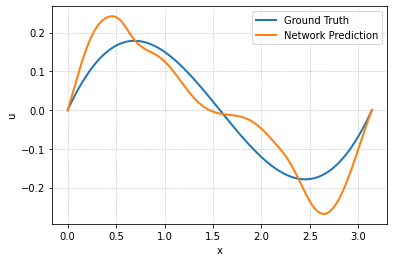

In [14]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [15]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  19.089312851428986 %


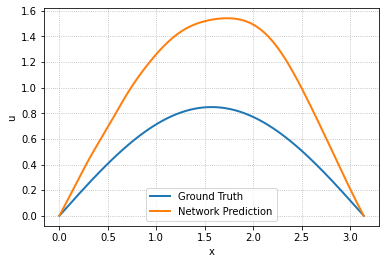

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  71.22331857681274 %


In [ ]:
#k = torch.autograd.functional.jacobian(my_network, test)

In [ ]:
#k.shape

In [ ]:
# for ploting

In [ ]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:



relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")